# Disney Character Popularity Predictor
Playful question: given the hero/villain/song DNA of a Disney movie, can we tell whether it will land in blockbuster territory (above-median inflation-adjusted domestic gross)? This notebook assembles the provided character and revenue datasets, engineers richer categorical signals, and tunes tree-based models to maximize accuracy.

## Workflow
1. Load the character, movie revenue, and director CSVs from `data/`.
2. Merge them on `movie_title`, standardize the date/currency columns, and craft higher-level signals (release decade/month, hero/villain archetypes, song metadata, director names).
3. Split the data with stratification and feed it to a preprocessing + modeling pipeline.
4. Grid-search both `RandomForestClassifier` and `HistGradientBoostingClassifier` to pick the best performer.
5. Evaluate on a held-out test set, visualize the confusion matrix, and inspect feature importance via permutation tests.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.inspection import permutation_importance

sns.set_theme(style='whitegrid')
DATA_DIR = Path('data')
RANDOM_STATE = 42

## Load the data
We will use three CSVs shipped with the repo:
- `disney-characters.csv`: hero, villain, signature song metadata per movie.
- `disney_movies_total_gross.csv`: genre, MPAA rating, and grosses (nominal + inflation-adjusted).
- `disney-director.csv`: director linked to each movie title.

The raw tables are tiny (47 overlapping titles), so every row counts.

In [2]:
characters = pd.read_csv(DATA_DIR / 'disney-characters.csv')
movies = pd.read_csv(DATA_DIR / 'disney_movies_total_gross.csv')
directors = pd.read_csv(DATA_DIR / 'disney-director.csv')

for df in (characters, movies, directors):
    df.columns = df.columns.str.strip()

characters['movie_title'] = characters['movie_title'].str.strip()
movies['movie_title'] = movies['movie_title'].str.strip()
directors['name'] = directors['name'].str.strip()

print(f"Characters shape: {characters.shape}")
print(f"Movies shape:     {movies.shape}")
print(f"Directors shape:  {directors.shape}")

display(characters.head())
display(movies.head())
display(directors.head())

Characters shape: (56, 6)
Movies shape:     (579, 7)
Directors shape:  (56, 3)


,index,movie_title,release_date,hero,villian,song
0,0,Snow White and the Seven Dwarfs,"December 21, 1937",Snow White,Evil Queen,Some Day My Prince Will Come
1,1,Pinocchio,"February 7, 1940",Pinocchio,Stromboli,When You Wish upon a Star
2,2,Fantasia,"November 13, 1940",NaN,Chernabog,NaN
3,3,Dumbo,"October 23, 1941",Dumbo,Ringmaster,Baby Mine
4,4,Bambi,"August 13, 1942",Bambi,Hunter,Love Is a Song


,index,movie_title,release_date,genre,MPAA_rating,total_gross,inflation_adjusted_gross
0,0,Snow White and the Seven Dwarfs,"Dec 21, 1937",Musical,G,"$184,925,485","$5,228,953,251"
1,1,Pinocchio,"Feb 9, 1940",Adventure,G,"$84,300,000","$2,188,229,052"
2,2,Fantasia,"Nov 13, 1940",Musical,G,"$83,320,000","$2,187,090,808"
3,3,Song of the South,"Nov 12, 1946",Adventure,G,"$65,000,000","$1,078,510,579"
4,4,Cinderella,"Feb 15, 1950",Drama,G,"$85,000,000","$920,608,730"


,index,name,director
0,0,Snow White and the Seven Dwarfs,David Hand
1,1,Pinocchio,Ben Sharpsteen
2,2,Fantasia,full credits
3,3,Dumbo,Ben Sharpsteen
4,4,Bambi,David Hand


## Feature engineering
Key steps:
- Merge characters ↔ movies ↔ directors by title.
- Parse release dates from both files, favoring the movie table where available.
- Clean the currency columns and derive the binary target `is_blockbuster` (>= median inflation-adjusted gross).
- Build helpful categorical cues (director name, release decade, hero/villain archetypes) and numeric cues (release month, song stats, has_signature_song flag).
- Keep a tidy modeling dataframe so later cells stay compact.

In [3]:
def clean_currency(series: pd.Series) -> pd.Series:
    return (
        series.astype(str)
        .str.replace('$', '', regex=False)
        .str.replace(',', '', regex=False)
        .replace({'nan': np.nan})
        .astype(float)
    )

ROYAL_KEYWORDS = ['princess', 'queen', 'king', 'prince', 'emperor', 'empress']
ANIMAL_KEYWORDS = ['mouse', 'lion', 'duck', 'dog', 'cat', 'tiger', 'bear', 'beast', 'fish', 'dragon', 'frog']

def categorize_character(name: str) -> str:
    text = str(name).lower()
    if any(k in text for k in ROYAL_KEYWORDS):
        return 'royal'
    if any(k in text for k in ANIMAL_KEYWORDS):
        return 'animal'
    if ' and ' in text or '&' in text:
        return 'ensemble'
    if text == 'unknown hero' or text == 'unknown villain':
        return 'unknown'
    return 'human'

merged = pd.merge(characters, movies, on='movie_title', suffixes=('_char', '_movie'))
merged = pd.merge(merged, directors[['name', 'director']], left_on='movie_title', right_on='name', how='left')
merged = merged.drop(columns=['name'])

for col in ['release_date_char', 'release_date_movie']:
    merged[col] = pd.to_datetime(merged[col], errors='coerce')

merged['release_year'] = merged['release_date_movie'].dt.year.fillna(merged['release_date_char'].dt.year)
merged['release_month'] = merged['release_date_movie'].dt.month.fillna(merged['release_date_char'].dt.month)
merged['release_decade'] = (merged['release_year'] // 10) * 10

for col in ['total_gross', 'inflation_adjusted_gross']:
    merged[col] = clean_currency(merged[col])

merged['hero'] = merged['hero'].fillna('Unknown Hero')
merged['villian'] = merged['villian'].fillna('Unknown Villain')
merged['song'] = merged['song'].fillna('No Song Listed')
merged['genre'] = merged['genre'].fillna('Unknown Genre')
merged['MPAA_rating'] = merged['MPAA_rating'].fillna('Not Rated')
merged['director'] = merged['director'].fillna('Unknown Director')

merged['release_year'] = merged['release_year'].fillna(merged['release_year'].median())
merged['release_month'] = merged['release_month'].fillna(6)
merged['release_decade'] = merged['release_decade'].fillna(merged['release_decade'].mode()[0])

merged['has_song'] = (merged['song'] != 'No Song Listed').astype(int)
merged['song_word_count'] = merged['song'].str.split().str.len().fillna(0)
merged['hero_archetype'] = merged['hero'].apply(categorize_character)
merged['villain_archetype'] = merged['villian'].apply(categorize_character)

median_gross = merged['inflation_adjusted_gross'].median()
merged['is_blockbuster'] = (merged['inflation_adjusted_gross'] >= median_gross).astype(int)

model_df = merged[[
    'movie_title', 'hero', 'hero_archetype', 'villian', 'villain_archetype', 'song',
    'has_song', 'song_word_count', 'genre', 'MPAA_rating', 'director',
    'release_year', 'release_month', 'release_decade', 'inflation_adjusted_gross', 'is_blockbuster'
]]

print(f"Merged rows: {model_df.shape[0]}")
display(model_df.head())

Merged rows: 47


,movie_title,hero,hero_archetype,villian,villain_archetype,song,has_song,song_word_count,genre,MPAA_rating,director,release_year,release_month,release_decade,inflation_adjusted_gross,is_blockbuster
0,Snow White and the Seven Dwarfs,Snow White,human,Evil Queen,royal,Some Day My Prince Will Come,1,6,Musical,G,David Hand,1937,12,1930,5.228953e+09,1
1,Pinocchio,Pinocchio,human,Stromboli,human,When You Wish upon a Star,1,6,Adventure,G,Ben Sharpsteen,1940,2,1940,2.188229e+09,1
2,Fantasia,Unknown Hero,unknown,Chernabog,human,No Song Listed,0,3,Musical,G,full credits,1940,11,1940,2.187091e+09,1
3,Cinderella,Cinderella,human,Lady Tremaine,human,Bibbidi-Bobbidi-Boo,1,1,Drama,G,Wilfred Jackson,1950,2,1950,9.206087e+08,1
4,Cinderella,Cinderella,human,Lady Tremaine,human,Bibbidi-Bobbidi-Boo,1,1,Drama,PG,Wilfred Jackson,2015,3,2010,2.011514e+08,1


### Quick sanity checks
Do the engineered numeric signals look sensible?

In [4]:
display(model_df[['release_year', 'release_month', 'release_decade', 'song_word_count']].describe())

,release_year,release_month,release_decade,song_word_count
count,47.000000,47.000000,47.000000,47.000000
mean,1991.148936,7.617021,1987.021277,3.425532
std,21.671439,3.448712,21.660914,1.584499
min,1937.000000,1.000000,1930.000000,0.000000
25%,1983.000000,5.500000,1980.000000,3.000000
50%,1997.000000,7.000000,1990.000000,3.000000
75%,2007.500000,11.000000,2000.000000,4.000000
max,2016.000000,12.000000,2010.000000,8.000000


Heroes linked to the highest inflation-adjusted grosses (top 10)

In [5]:
hero_popularity = (
    model_df.groupby('hero')['inflation_adjusted_gross']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
hero_popularity.rename('avg_infl_adj_gross').round(0)

hero
Snow White        5.228953e+09
Pinocchio         2.188229e+09
Unknown Hero      2.187091e+09
Lady and Tramp    1.236036e+09
Simba             7.616409e+08
Cinderella        5.608800e+08
Aladdin           4.419692e+08
Elsa              4.149972e+08
Mowgli            4.141813e+08
Belle             3.630177e+08
Name: avg_infl_adj_gross, dtype: float64

## Train/test split
Stratified split keeps the blockbuster / modest-hit classes balanced despite the tiny sample.

In [6]:
feature_cols = [
    'hero', 'hero_archetype', 'villian', 'villain_archetype', 'song', 'genre',
    'MPAA_rating', 'director', 'release_decade'
]
numeric_cols = ['release_year', 'release_month', 'has_song', 'song_word_count']

X = model_df[feature_cols + numeric_cols]
y = model_df['is_blockbuster']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print(f"Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")

Train size: 37 | Test size: 10


## Modeling + optimization
We wrap preprocessing + modeling in a single pipeline and search over two tree families:
- `RandomForestClassifier` (bagging, good with sparse one-hot features).
- `HistGradientBoostingClassifier` (oblivious trees; strong on tabular data).

This small grid keeps runtime manageable while still exploring depth/learning-rate trade-offs.

In [7]:
categorical_features = feature_cols
numeric_features = numeric_cols

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=2), categorical_features),
        ('num', 'passthrough', numeric_features),
    ]
)

pipe = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'clf': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'clf__n_estimators': [200, 400, 800],
        'clf__max_depth': [None, 6, 12],
        'clf__min_samples_split': [2, 4],
        'clf__min_samples_leaf': [1, 2],
    },
    {
        'clf': [HistGradientBoostingClassifier(random_state=RANDOM_STATE)],
        'clf__learning_rate': [0.05, 0.1, 0.2],
        'clf__max_depth': [None, 6, 12],
        'clf__max_leaf_nodes': [15, 31, 63],
    }
]

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)
print(f"Best params: {grid.best_params_}")
print(f"Best CV accuracy: {grid.best_score_:.3f}")

Fitting 5 folds for each of 63 candidates, totalling 315 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
54 fits failed out of a total of 315.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimato

Best params: {'clf': RandomForestClassifier(random_state=42), 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 800}
Best CV accuracy: 0.564


## Test validation
Evaluate the best pipeline on the held-out set, and visualize the confusion matrix.

Test accuracy: 0.900
Test F1: 0.909

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



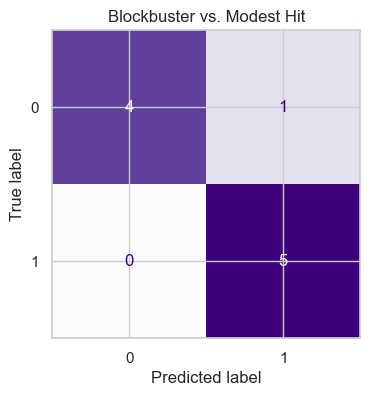

In [8]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Test accuracy: {test_accuracy:.3f}")
print(f"Test F1: {test_f1:.3f}")
print()
print("Classification report:")
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Purples', colorbar=False)
ax.set_title('Blockbuster vs. Modest Hit')
plt.show()

## Feature signals
Permutation importance (on the trained pipeline) highlights which engineered signals move the needle the most.

In [9]:
perm = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=RANDOM_STATE)
feature_names = X_test.columns
importance_df = (
    pd.DataFrame({'feature': feature_names, 'importance': perm.importances_mean})
    .sort_values('importance', ascending=False)
    .head(15)
)
importance_df

,feature,importance
6,MPAA_rating,0.203333
8,release_decade,0.190000
5,genre,0.086667
9,release_year,0.050000
7,director,0.043333
3,villain_archetype,0.023333
0,hero,0.000000
1,hero_archetype,0.000000
2,villian,0.000000
4,song,0.000000
